In [14]:
# Exploratory Data Analysis — Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

project_root = Path.cwd().parent
asset_universe = pd.read_csv(project_root / 'data/asset_universe.csv')
prices = pd.read_csv(project_root / 'data/raw/all_close_prices.csv', index_col=0, parse_dates=True)
returns = prices.pct_change().dropna()

print(f"✅ Loaded: {prices.shape} prices, {returns.shape} returns")

etf_tickers = asset_universe[asset_universe['Type'] == 'ETF']['Ticker'].tolist()
stock_tickers = asset_universe[asset_universe['Type'] == 'Stock']['Ticker'].tolist()


✅ Loaded: (1381, 55) prices, (1380, 55) returns


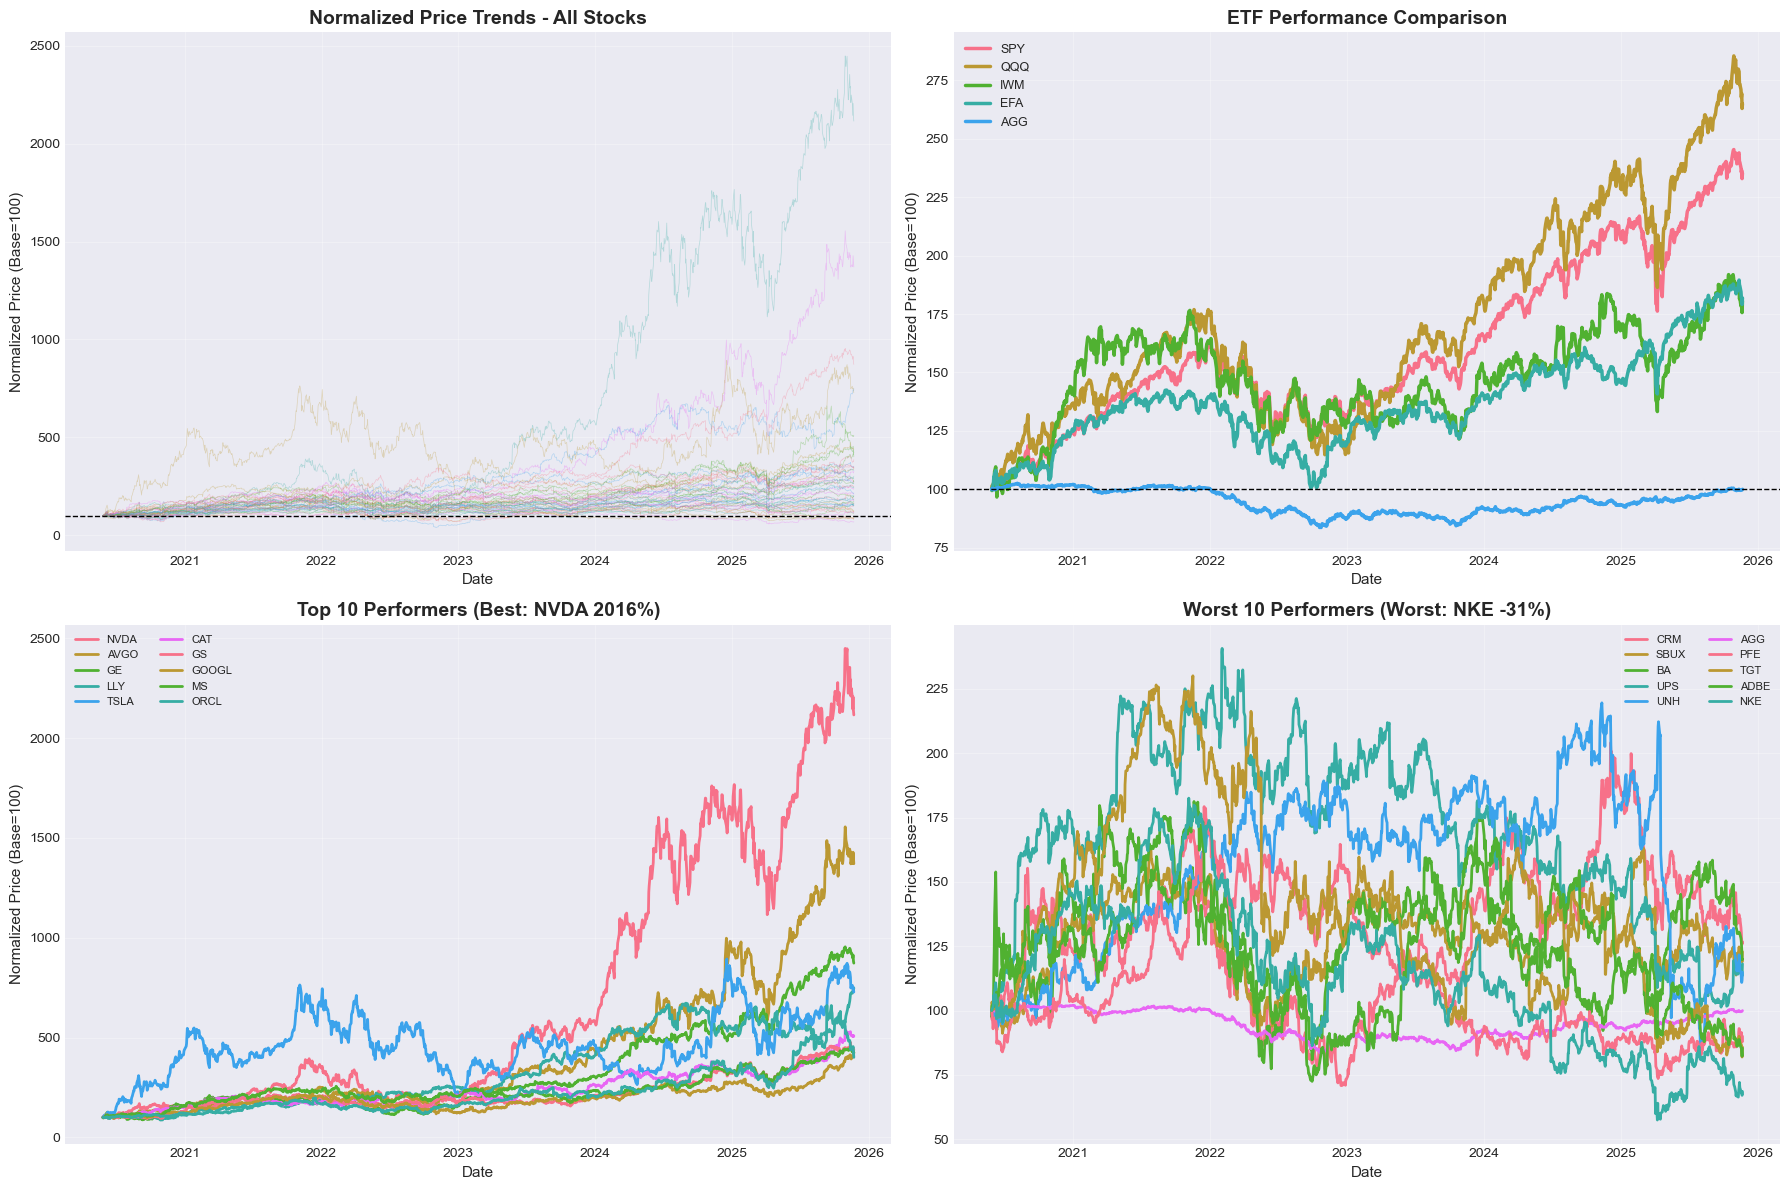

In [15]:
# Price Trends Visualization

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
normalized_prices = (prices / prices.iloc[0]) * 100

# Plot All Stocks
ax1 = axes[0, 0]
for col in stock_tickers:
    if col in normalized_prices.columns:
        ax1.plot(normalized_prices.index, normalized_prices[col], alpha=0.3, linewidth=0.5)
ax1.set_title('Normalized Price Trends - All Stocks', fontsize=14, fontweight='bold')
ax1.set_ylabel('Normalized Price (Base=100)', fontsize=11)
ax1.set_xlabel('Date', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=100, color='black', linestyle='--', linewidth=1)

# Plot ETFs only
ax2 = axes[0, 1]
for etf in etf_tickers:
    if etf in normalized_prices.columns:
        ax2.plot(normalized_prices.index, normalized_prices[etf], label=etf, linewidth=2.5)
ax2.set_title('ETF Performance Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Normalized Price (Base=100)', fontsize=11)
ax2.set_xlabel('Date', fontsize=11)
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=100, color='black', linestyle='--', linewidth=1)

# Top 10 performers
total_returns = (prices.iloc[-1] / prices.iloc[0] - 1).sort_values(ascending=False)
top_10 = total_returns.head(10).index
ax3 = axes[1, 0]
for ticker in top_10:
    ax3.plot(normalized_prices.index, normalized_prices[ticker], label=ticker, linewidth=2)
best_perf_ticker = top_10[0]
ax3.set_title(f'Top 10 Performers (Best: {best_perf_ticker} {total_returns[best_perf_ticker]*100:.0f}%)',
              fontsize=14, fontweight='bold')
ax3.set_ylabel('Normalized Price (Base=100)', fontsize=11)
ax3.set_xlabel('Date', fontsize=11)
ax3.legend(ncol=2, fontsize=8, loc='upper left')
ax3.grid(True, alpha=0.3)

# Worst 10 performers (Fixes .iloc error: use [-1], not .iloc)
worst_10 = total_returns.tail(10).index
ax4 = axes[1, 1]
for ticker in worst_10:
    ax4.plot(normalized_prices.index, normalized_prices[ticker], label=ticker, linewidth=2)
worst_perf_ticker = worst_10[-1]   # Correct way to get last ticker from Index
ax4.set_title(f'Worst 10 Performers (Worst: {worst_perf_ticker} {total_returns[worst_perf_ticker]*100:.0f}%)', 
              fontsize=14, fontweight='bold')
ax4.set_ylabel('Normalized Price (Base=100)', fontsize=11)
ax4.set_xlabel('Date', fontsize=11)
ax4.legend(ncol=2, fontsize=8, loc='upper right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'results/figures/eda/01_price_trends.png', dpi=300, bbox_inches='tight')
plt.show()


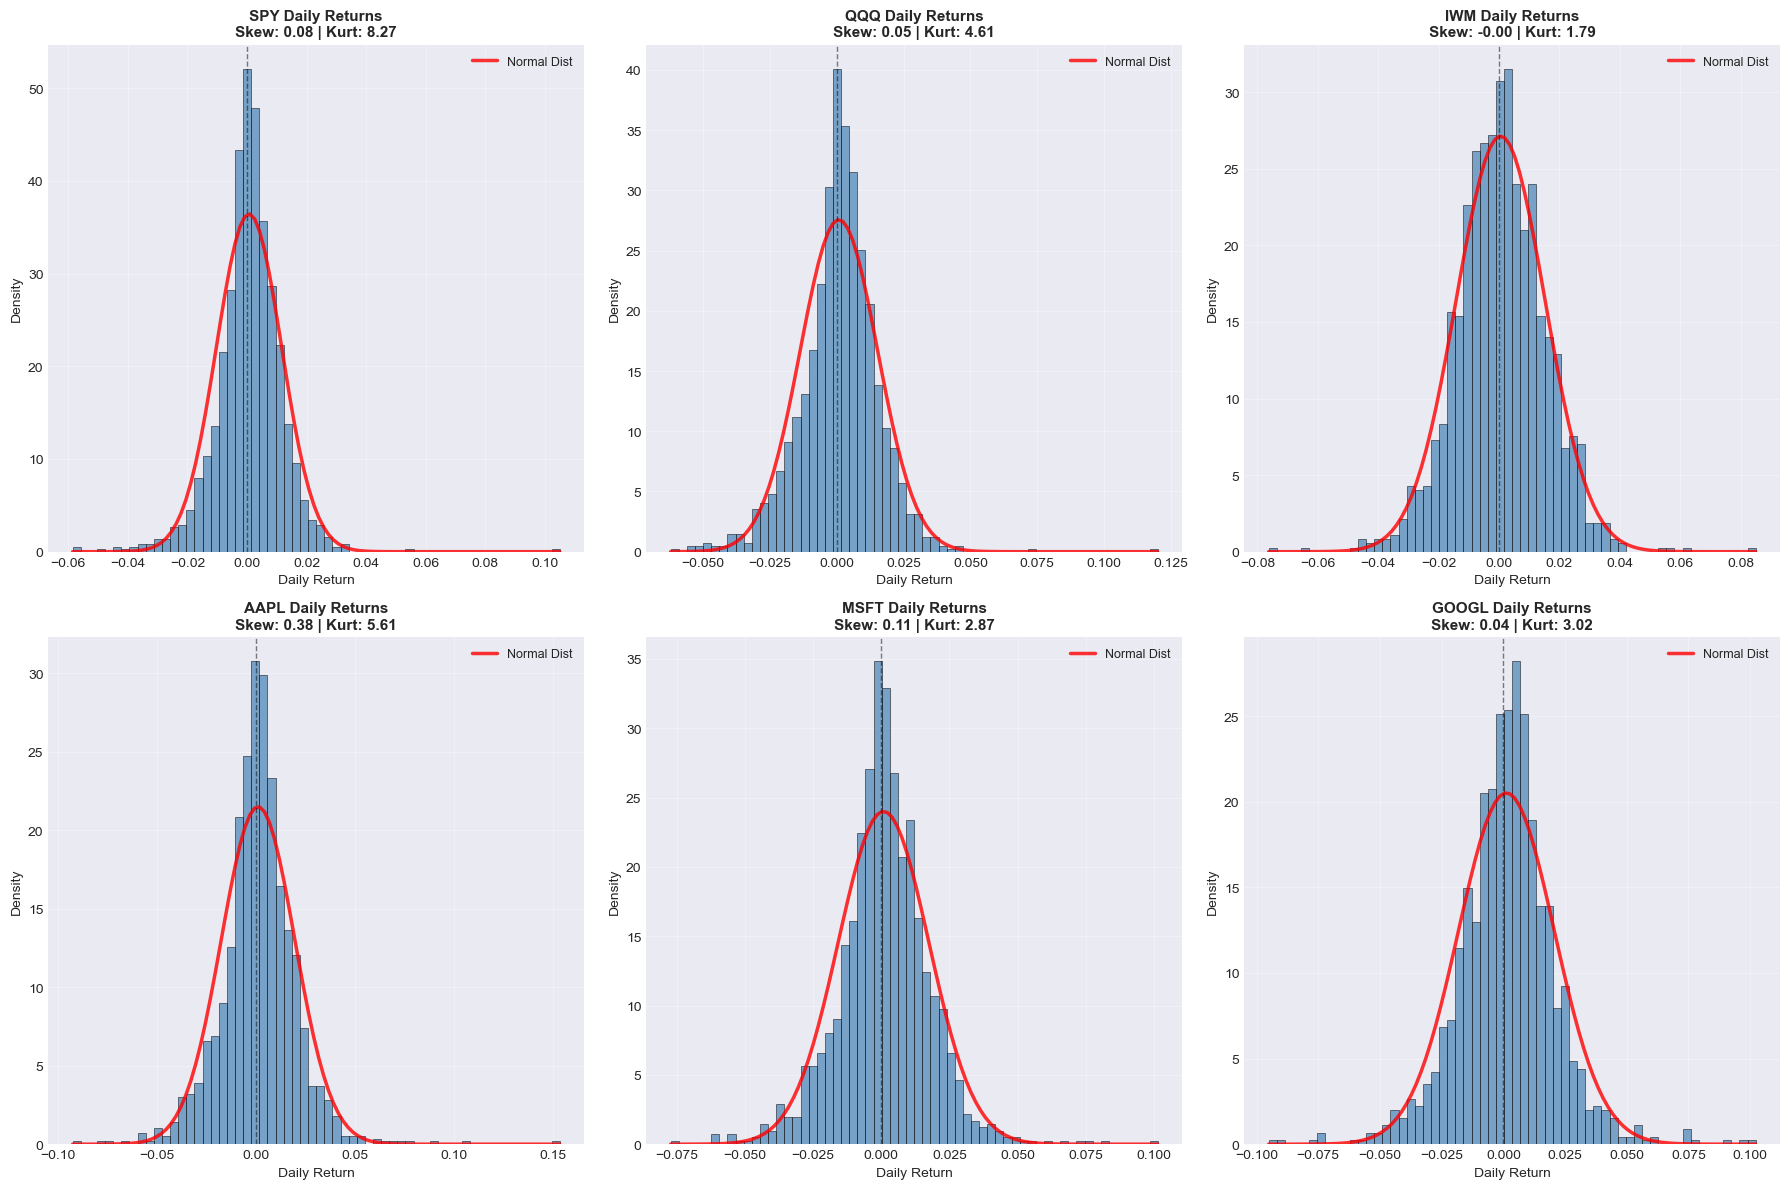

JARQUE-BERA NORMALITY TESTS
SPY           3935.12       0.00e+00 Non-Normal
QQQ           1220.08      1.16e-265 Non-Normal
IWM            184.84       7.27e-41 Non-Normal
AAPL          1841.91       0.00e+00 Non-Normal
MSFT           477.52      2.03e-104 Non-Normal
GOOGL          523.20      2.44e-114 Non-Normal


In [16]:
# Return Distributions: Histogram & Normality Tests

sample_tickers = []
for asset_type in ['ETF', 'Stock']:
    sample_tickers.extend(asset_universe[asset_universe['Type'] == asset_type]['Ticker'].head(3).tolist())

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, ticker in enumerate(sample_tickers):
    if ticker not in returns.columns: continue
    row, col = idx // 3, idx % 3
    ax = axes[row, col]
    ticker_returns = returns[ticker].dropna()
    ax.hist(ticker_returns, bins=60, density=True, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
    mu, sigma = ticker_returns.mean(), ticker_returns.std()
    x = np.linspace(ticker_returns.min(), ticker_returns.max(), 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2.5, label='Normal Dist', alpha=0.8)
    skew, kurt = stats.skew(ticker_returns), stats.kurtosis(ticker_returns)
    ax.set_title(f'{ticker} Daily Returns\nSkew: {skew:.2f} | Kurt: {kurt:.2f}', fontweight='bold', fontsize=11)
    ax.set_xlabel('Daily Return', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig(project_root / 'results/figures/eda/02_return_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("="*70)
print("JARQUE-BERA NORMALITY TESTS")
for ticker in sample_tickers:
    if ticker in returns.columns:
        ticker_returns = returns[ticker].dropna()
        jb_stat, jb_pvalue = stats.jarque_bera(ticker_returns)
        print(f"{ticker:10} {jb_stat:10.2f} {jb_pvalue:14.2e} {'Normal' if jb_pvalue>0.05 else 'Non-Normal'}")


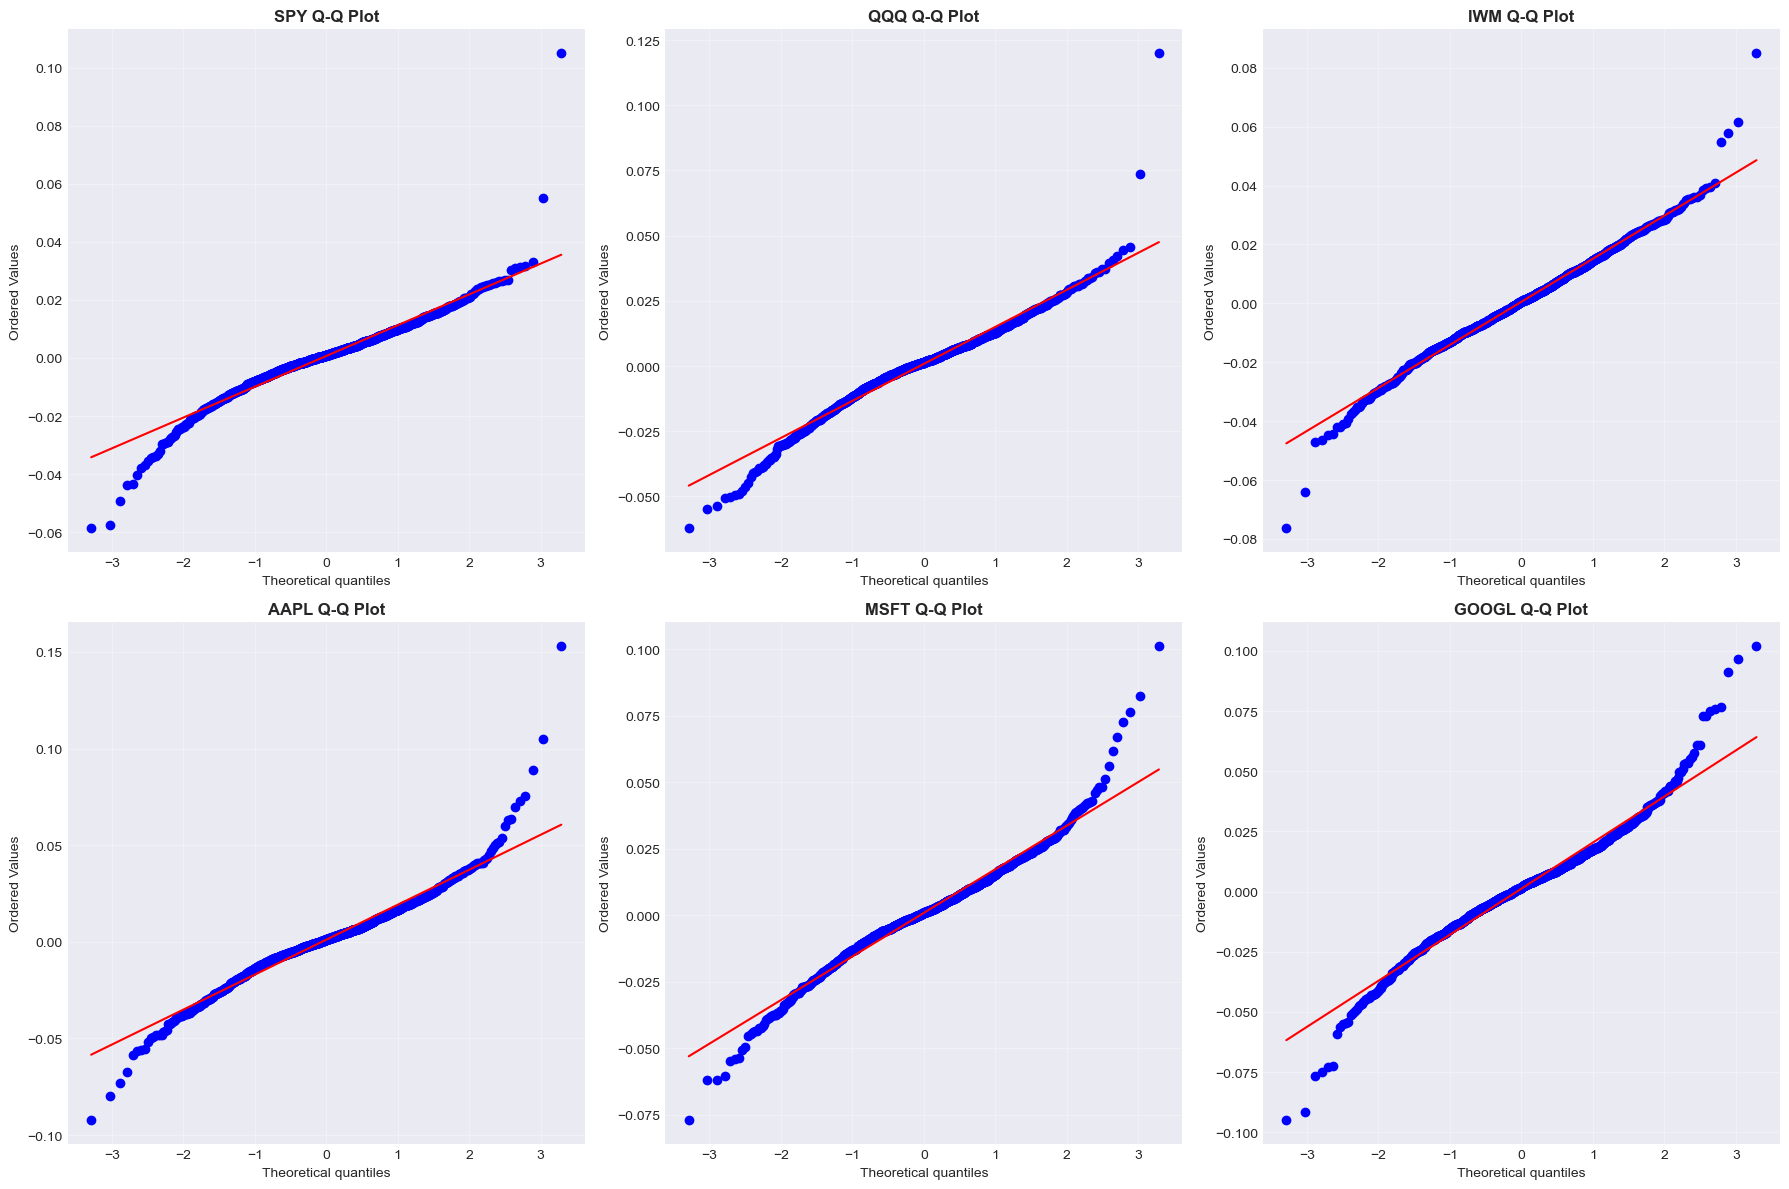

In [17]:
# QQ plots

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
for idx, ticker in enumerate(sample_tickers):
    if ticker not in returns.columns: continue
    row, col = idx // 3, idx % 3
    ax = axes[row, col]
    ticker_returns = returns[ticker].dropna()
    stats.probplot(ticker_returns, dist="norm", plot=ax)
    ax.set_title(f'{ticker} Q-Q Plot', fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(project_root / 'results/figures/eda/03_qq_plots.png', dpi=300, bbox_inches='tight')
plt.show()


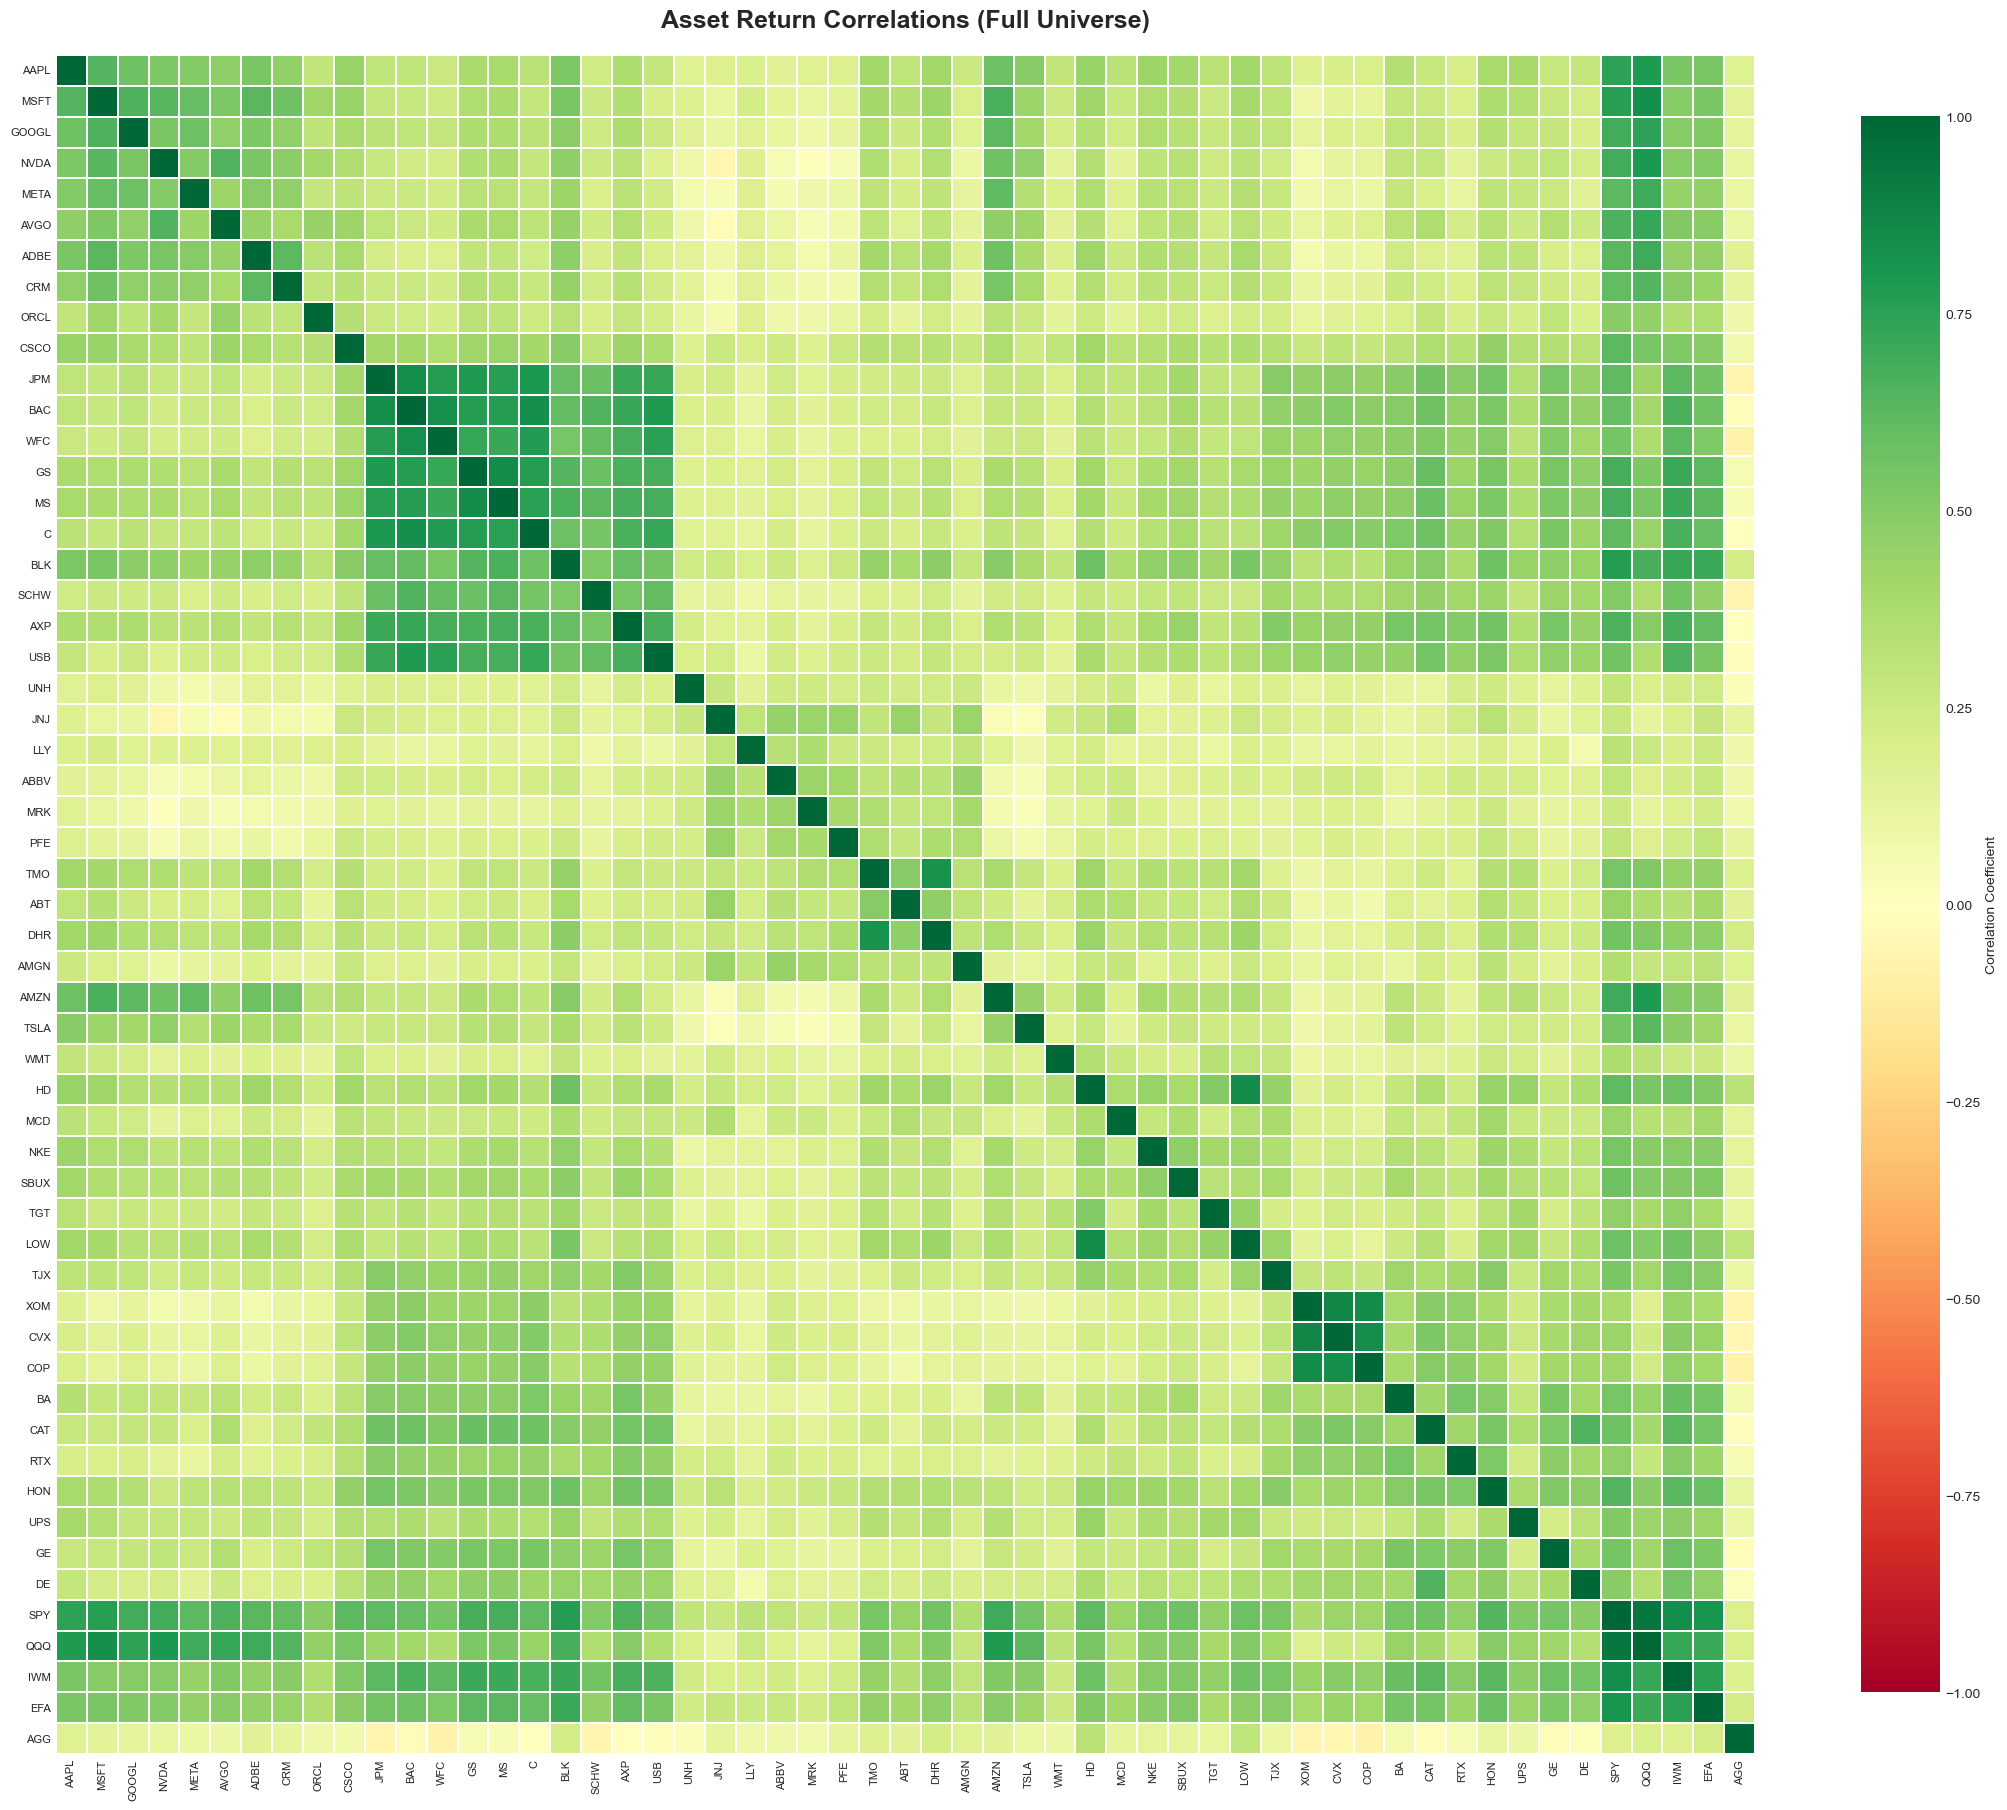

In [18]:
# Correlation heatmap for all assets

corr_matrix = returns.corr()
fig, ax = plt.subplots(figsize=(22, 20))
sns.heatmap(corr_matrix, cmap='RdYlGn', center=0, vmin=-1, vmax=1, square=True,
            linewidths=0.1, cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
            ax=ax, annot=False, fmt='.2f', xticklabels=True, yticklabels=True)
ax.set_title('Asset Return Correlations (Full Universe)', fontsize=18, fontweight='bold', pad=20)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig(project_root / 'results/figures/eda/04_correlation_heatmap_full.png', dpi=300, bbox_inches='tight')
plt.show()


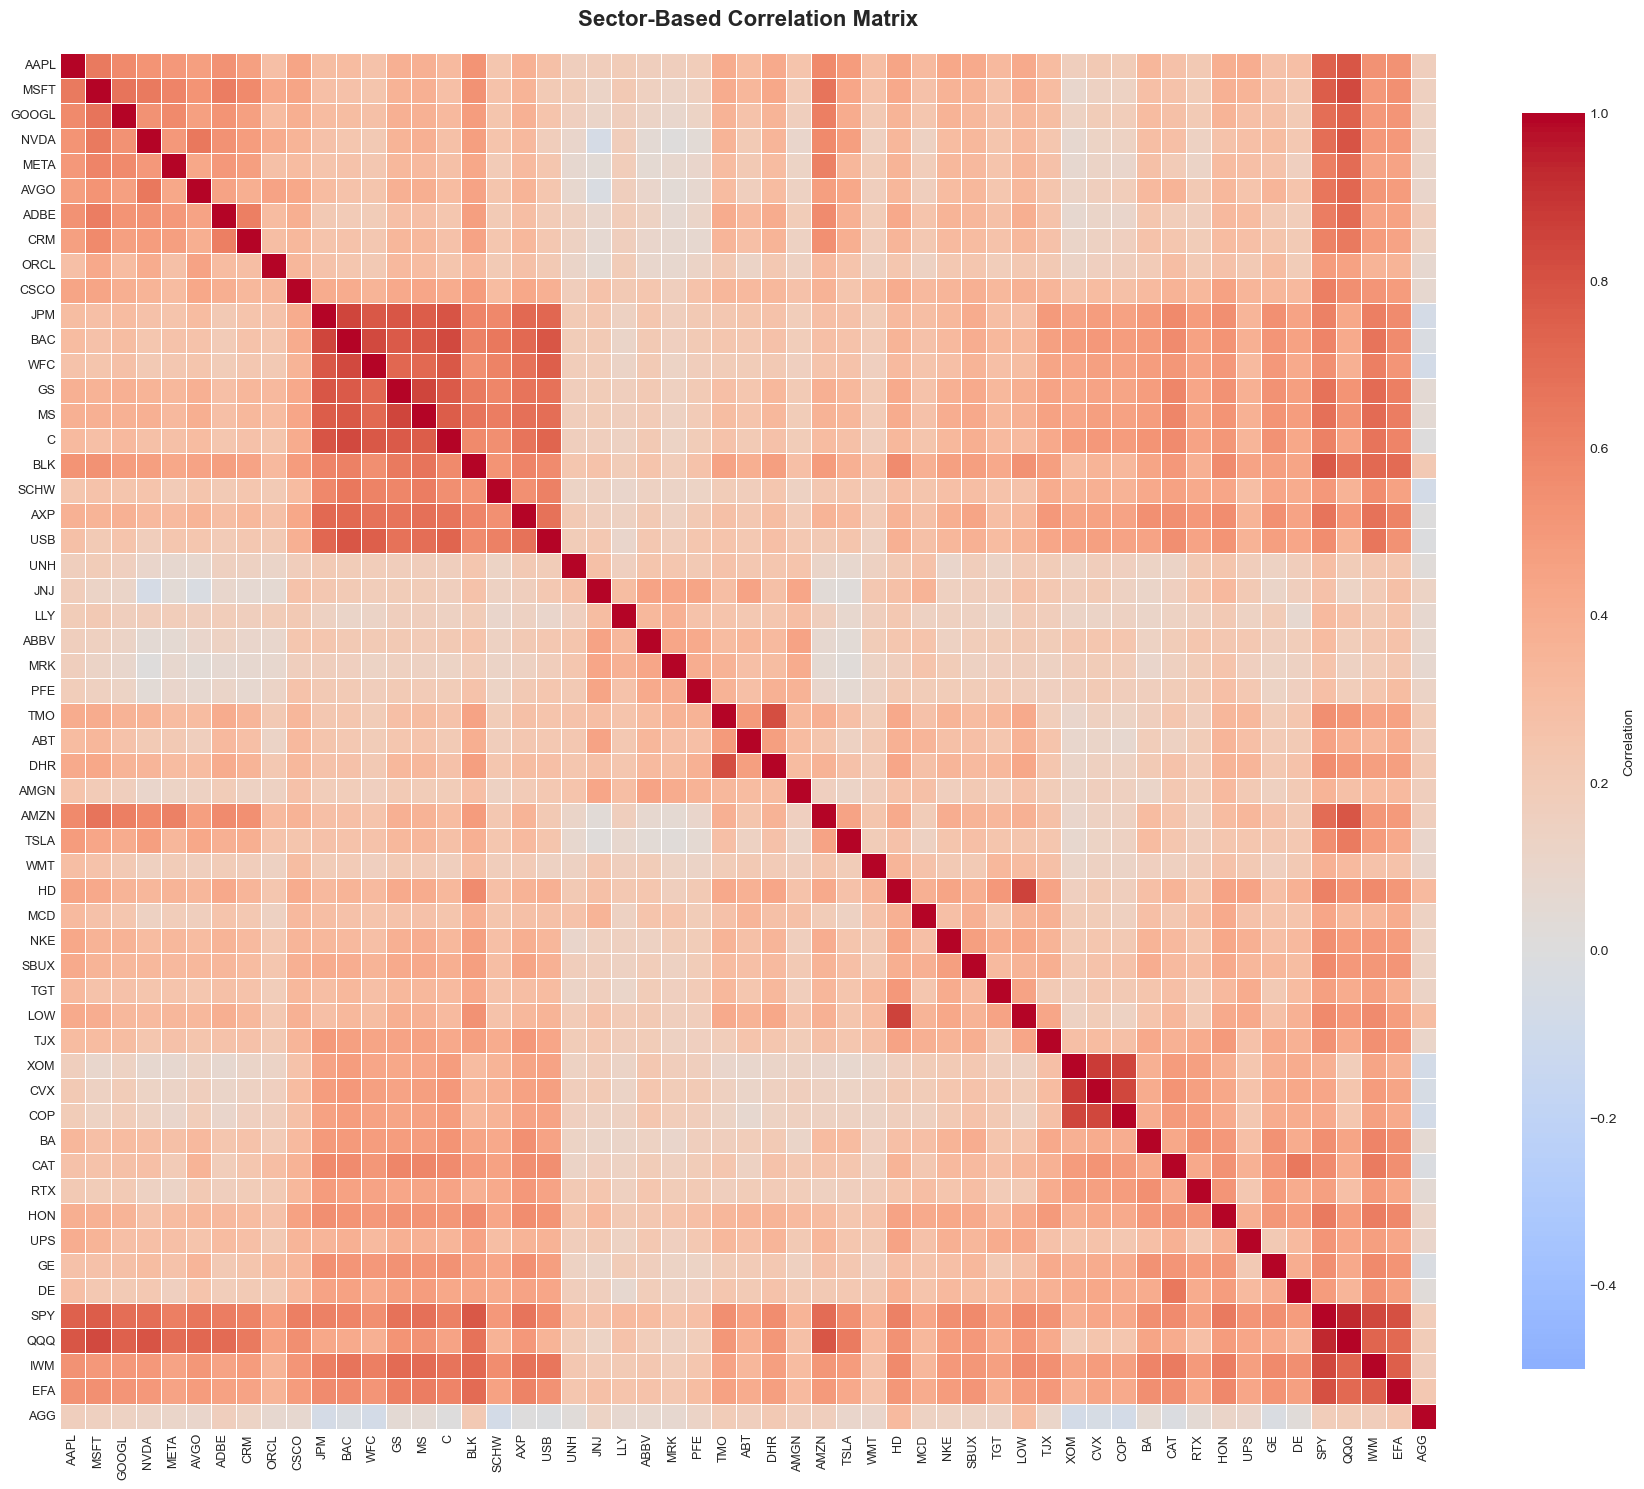

In [19]:
# Focused correlation heatmap by sector

sectors = {
    'Tech': ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'META', 'AVGO', 'ADBE', 'CRM', 'ORCL', 'CSCO'],
    'Finance': ['JPM', 'BAC', 'WFC', 'GS', 'MS', 'C', 'BLK', 'SCHW', 'AXP', 'USB'],
    'Healthcare': ['UNH', 'JNJ', 'LLY', 'ABBV', 'MRK', 'PFE', 'TMO', 'ABT', 'DHR', 'AMGN'],
    'Consumer': ['AMZN', 'TSLA', 'WMT', 'HD', 'MCD', 'NKE', 'SBUX', 'TGT', 'LOW', 'TJX'],
    'Energy/Ind': ['XOM', 'CVX', 'COP', 'BA', 'CAT', 'RTX', 'HON', 'UPS', 'GE', 'DE'],
    'ETFs': ['SPY', 'QQQ', 'IWM', 'EFA', 'AGG']
}
sector_tickers = [t for group in sectors.values() for t in group if t in returns.columns]
sector_corr = returns[sector_tickers].corr()
fig, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(sector_corr, annot=False, fmt='.2f', cmap='coolwarm', center=0, vmin=-0.5, vmax=1,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8, "label": "Correlation"},
            ax=ax, xticklabels=sector_tickers, yticklabels=sector_tickers)
ax.set_title('Sector-Based Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig(project_root / 'results/figures/eda/05_sector_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


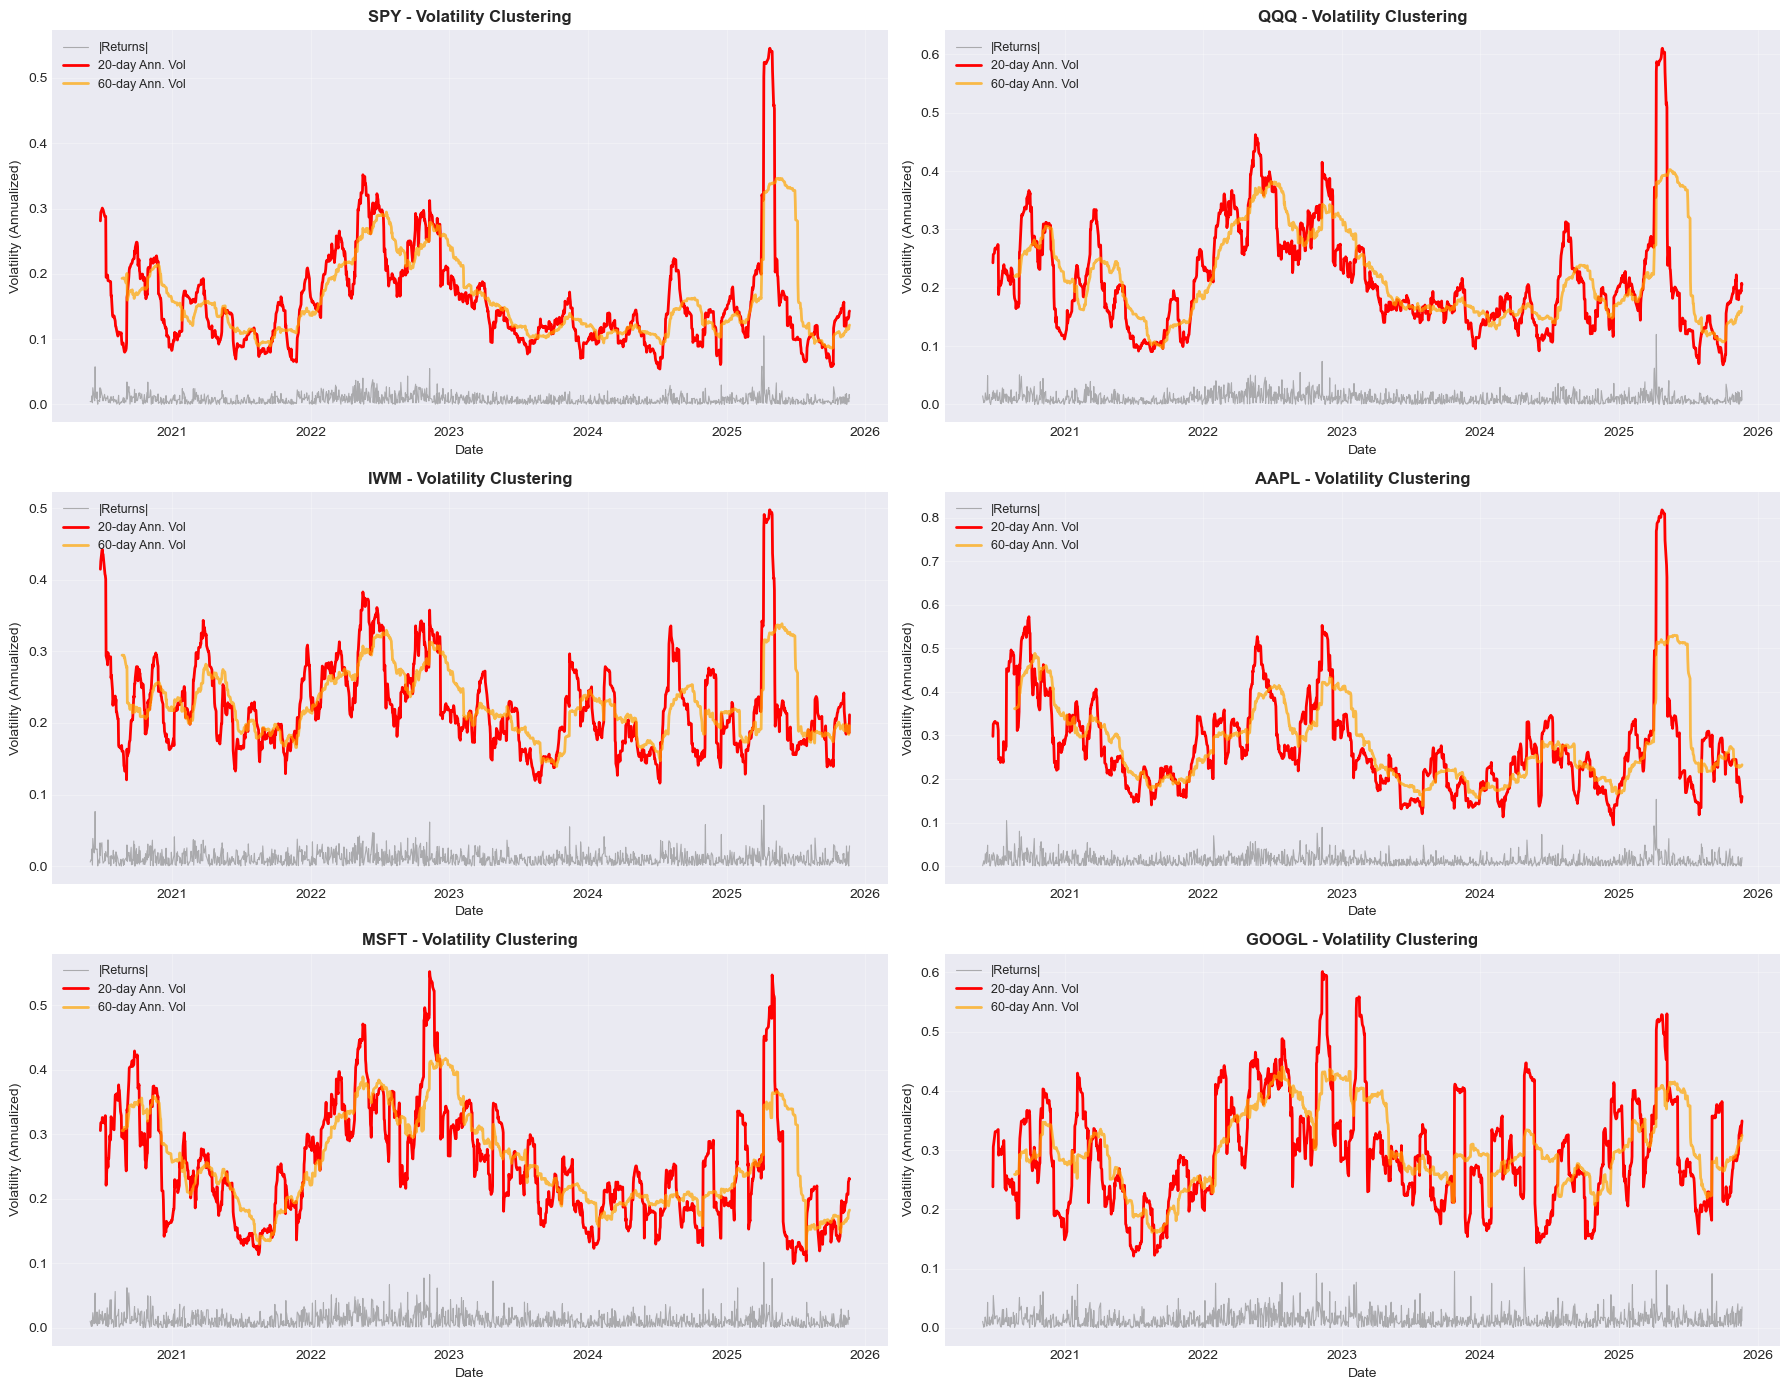

In [20]:
# Volatility clustering analysis

fig, axes = plt.subplots(3, 2, figsize=(18, 14))
for idx, ticker in enumerate(sample_tickers):
    if ticker not in returns.columns: continue
    row, col = idx // 2, idx % 2
    ax = axes[row, col]
    ticker_returns = returns[ticker].dropna()
    abs_returns = np.abs(ticker_returns)
    ax.plot(ticker_returns.index, abs_returns, alpha=0.6, linewidth=0.8, label='|Returns|', color='gray')
    rolling_vol_20 = ticker_returns.rolling(window=20).std() * np.sqrt(252)
    ax.plot(ticker_returns.index, rolling_vol_20, color='red', linewidth=2, label='20-day Ann. Vol')
    rolling_vol_60 = ticker_returns.rolling(window=60).std() * np.sqrt(252)
    ax.plot(ticker_returns.index, rolling_vol_60, color='orange', linewidth=2, label='60-day Ann. Vol', alpha=0.7)
    ax.set_title(f'{ticker} - Volatility Clustering', fontweight='bold', fontsize=12)
    ax.set_ylabel('Volatility (Annualized)', fontsize=10)
    ax.set_xlabel('Date', fontsize=10)
    ax.legend(fontsize=9, loc='upper left')
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(project_root / 'results/figures/eda/06_volatility_clustering.png', dpi=300, bbox_inches='tight')
plt.show()


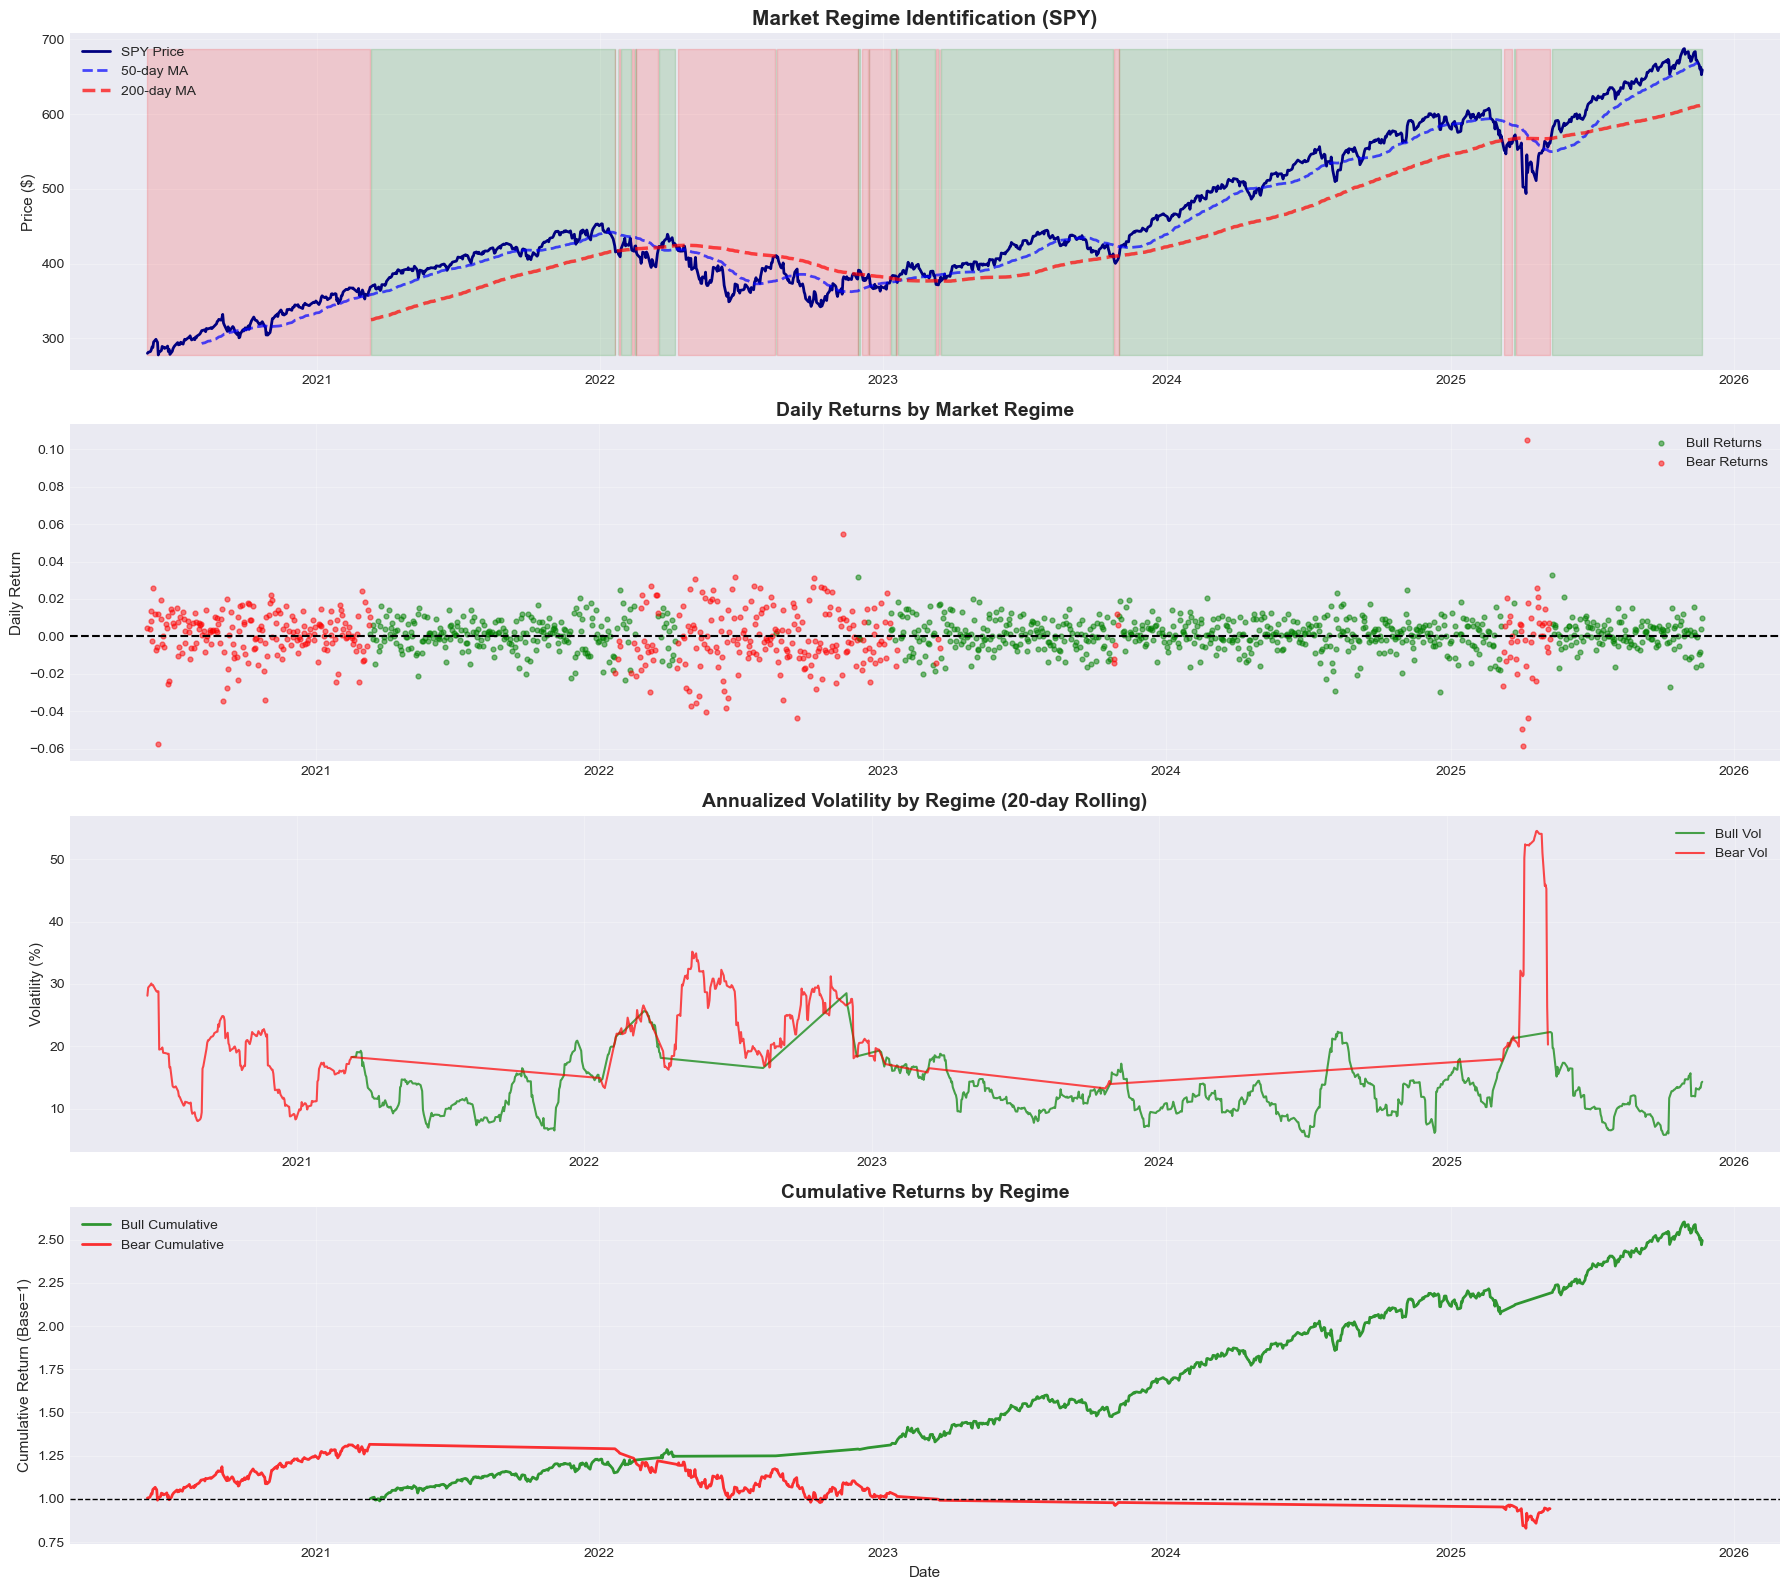

In [21]:
# Market Regime Identification

spy_ticker = 'SPY' if 'SPY' in prices.columns else etf_tickers[0]
spy_prices = prices[spy_ticker]
spy_returns = returns[spy_ticker]
ma_50 = spy_prices.rolling(window=50).mean()
ma_200 = spy_prices.rolling(window=200).mean()
regimes = pd.DataFrame(index=spy_prices.index)
regimes['price'] = spy_prices
regimes['ma_50'] = ma_50
regimes['ma_200'] = ma_200
regimes['regime'] = np.where(spy_prices > ma_200, 'Bull', 'Bear')
regimes['ma_cross'] = np.where(ma_50 > ma_200, 'Golden', 'Death')

fig, axes = plt.subplots(4, 1, figsize=(18, 16))
ax1 = axes[0]
ax1.plot(spy_prices.index, spy_prices, label=f'{spy_ticker} Price', linewidth=2, color='navy')
ax1.plot(ma_50.index, ma_50, label='50-day MA', linewidth=2, linestyle='--', color='blue', alpha=0.7)
ax1.plot(ma_200.index, ma_200, label='200-day MA', linewidth=2.5, linestyle='--', color='red', alpha=0.7)
bull_periods = regimes['regime'] == 'Bull'
ax1.fill_between(spy_prices.index, spy_prices.min(), spy_prices.max(), where=bull_periods, alpha=0.15, color='green')
ax1.fill_between(spy_prices.index, spy_prices.min(), spy_prices.max(), where=~bull_periods, alpha=0.15, color='red')
ax1.set_title(f'Market Regime Identification ({spy_ticker})', fontsize=15, fontweight='bold')
ax1.set_ylabel('Price ($)', fontsize=11)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax2 = axes[1]
bull_returns = spy_returns[regimes['regime'] == 'Bull']
bear_returns = spy_returns[regimes['regime'] == 'Bear']
ax2.scatter(bull_returns.index, bull_returns, c='green', alpha=0.5, s=12, label='Bull Returns')
ax2.scatter(bear_returns.index, bear_returns, c='red', alpha=0.5, s=12, label='Bear Returns')
ax2.axhline(0, color='black', linewidth=1.5, linestyle='--')
ax2.set_title('Daily Returns by Market Regime', fontsize=14, fontweight='bold')
ax2.set_ylabel('Daily Return', fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax3 = axes[2]
rolling_vol = spy_returns.rolling(window=20).std() * np.sqrt(252) * 100
bull_vol = rolling_vol[regimes['regime'] == 'Bull']
bear_vol = rolling_vol[regimes['regime'] == 'Bear']
ax3.plot(bull_vol.index, bull_vol, color='green', alpha=0.7, linewidth=1.5, label='Bull Vol')
ax3.plot(bear_vol.index, bear_vol, color='red', alpha=0.7, linewidth=1.5, label='Bear Vol')
ax3.set_title('Annualized Volatility by Regime (20-day Rolling)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Volatility (%)', fontsize=11)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax4 = axes[3]
bull_cumret = (1 + bull_returns).cumprod()
bear_cumret = (1 + bear_returns).cumprod()
ax4.plot(bull_cumret.index, bull_cumret, color='green', linewidth=2, label='Bull Cumulative', alpha=0.8)
ax4.plot(bear_cumret.index, bear_cumret, color='red', linewidth=2, label='Bear Cumulative', alpha=0.8)
ax4.axhline(1, color='black', linewidth=1, linestyle='--')
ax4.set_title('Cumulative Returns by Regime', fontsize=14, fontweight='bold')
ax4.set_ylabel('Cumulative Return (Base=1)', fontsize=11)
ax4.set_xlabel('Date', fontsize=11)
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(project_root / 'results/figures/eda/07_market_regimes.png', dpi=300, bbox_inches='tight')
plt.show()


In [22]:
# EDA Summary Report

upper_triangle = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
total_days = len(regimes.dropna())
bull_days = (regimes['regime'] == 'Bull').sum()
bear_days = (regimes['regime'] == 'Bear').sum()
bull_sharpe = (bull_returns.mean() / bull_returns.std()) * np.sqrt(252)
bear_sharpe = (bear_returns.mean() / bear_returns.std()) * np.sqrt(252)

eda_summary = {
    'Dataset Info': {
        'Total Assets': len(prices.columns),
        'Stocks': len(stock_tickers),
        'ETFs': len(etf_tickers),
        'Date Range': f"{prices.index[0].date()} to {prices.index[-1].date()}",
        'Trading Days': len(prices),
        'Missing Data %': f"{(prices.isnull().sum().sum() / (len(prices) * len(prices.columns)) * 100):.2f}%",
    },
    'Return Statistics': {
        'Mean Daily Return (avg)': f"{returns.mean().mean() * 100:.4f}%",
        'Median Daily Return (avg)': f"{returns.median().median() * 100:.4f}%",
        'Std Dev (avg)': f"{returns.std().mean() * 100:.4f}%",
        'Annualized Vol (avg)': f"{returns.std().mean() * np.sqrt(252) * 100:.2f}%",
        'Skewness (avg)': f"{returns.skew().mean():.3f}",
        'Kurtosis (avg)': f"{returns.kurtosis().mean():.3f}",
        'Max Single Day Gain': f"{returns.max().max() * 100:.2f}%",
        'Max Single Day Loss': f"{returns.min().min() * 100:.2f}%",
    },
    'Correlation Analysis': {
        'Mean Pairwise Corr': f"{upper_triangle.mean():.3f}",
        'Median Pairwise Corr': f"{np.median(upper_triangle):.3f}",
        'Max Correlation': f"{upper_triangle.max():.3f}",
        'Min Correlation': f"{upper_triangle.min():.3f}",
        '% Positive Correlations': f"{(upper_triangle > 0).sum() / len(upper_triangle) * 100:.1f}%",
        '% High Corr (>0.7)': f"{(upper_triangle > 0.7).sum() / len(upper_triangle) * 100:.1f}%",
    },
    'Market Regimes': {
        'Bull Market Days': f"{bull_days:,} ({bull_days/total_days*100:.1f}%)",
        'Bear Market Days': f"{bear_days:,} ({bear_days/total_days*100:.1f}%)",
        'Bull Avg Return (Ann)': f"{bull_returns.mean()*252*100:.2f}%",
        'Bear Avg Return (Ann)': f"{bear_returns.mean()*252*100:.2f}%",
        'Bull Avg Vol': f"{bull_vol.mean():.2f}%",
        'Bear Avg Vol': f"{bear_vol.mean():.2f}%",
        'Bull Sharpe': f"{bull_sharpe:.2f}",
        'Bear Sharpe': f"{bear_sharpe:.2f}",
    }
}

print("\n" + "="*70)
print("EXPLORATORY DATA ANALYSIS - SUMMARY REPORT")
for section, metrics in eda_summary.items():
    print(f"\n{section}:")
    print("-" * 70)
    for key, value in metrics.items():
        print(f"  {key:.<50} {value:>18}")

# Save summary — FIXES NameError by using imported datetime
summary_text = []
summary_text.append("="*70)
summary_text.append("EXPLORATORY DATA ANALYSIS - SUMMARY REPORT")
summary_text.append("="*70)
summary_text.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
summary_text.append("")
for section, metrics in eda_summary.items():
    summary_text.append(f"\n{section}:")
    summary_text.append("-" * 70)
    for key, value in metrics.items():
        summary_text.append(f"  {key:.<50} {value:>18}")
with open(project_root / 'results/metrics/02_eda_summary_report.txt', 'w') as f:
    f.write('\n'.join(summary_text))

print(f"\n✅ EDA summary saved to results/metrics/02_eda_summary_report.txt")



EXPLORATORY DATA ANALYSIS - SUMMARY REPORT

Dataset Info:
----------------------------------------------------------------------
  Total Assets......................................                 55
  Stocks............................................                 50
  ETFs..............................................                  5
  Date Range........................................ 2020-05-28 to 2025-11-21
  Trading Days......................................               1381
  Missing Data %....................................              0.00%

Return Statistics:
----------------------------------------------------------------------
  Mean Daily Return (avg)...........................            0.0821%
  Median Daily Return (avg).........................            0.0740%
  Std Dev (avg).....................................            1.8379%
  Annualized Vol (avg)..............................             29.18%
  Skewness (avg).................................... 